In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

### Importujemy dane z plików test i train oraz łączymy je w jeden. Wybieram 5 losowych kolumn.

In [2]:
X_test = pd.read_csv('../Files/samsung_test.txt', sep=r"\s+", header=None)
X_train = pd.read_csv('../Files/samsung_train.txt', sep=r"\s+", header=None)
X_data = pd.concat([X_train, X_test], ignore_index=True)
X_data.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [3]:
X = X_data[[200, 400]].to_numpy()
X

array([[-0.95943388, -0.99972876],
       [-0.97928915, -0.99968546],
       [-0.98370313, -0.99962746],
       ...,
       [-0.2076032 , -0.8113725 ],
       [-0.23386573, -0.93850257],
       [-0.22430899, -0.93893901]])

### Importujemy labelki z plików test i train oraz łączymy je w jeden

In [4]:
y_test = pd.read_csv('../Files/samsung_test_labels.txt', sep=r"\s+", header=None)
y_train = pd.read_csv('../Files/samsung_train_labels.txt', sep=r"\s+", header=None)
y = pd.concat([y_train, y_test], ignore_index=True)
y
y = y.to_numpy()

In [5]:
labels_dict = {
    1.0: 'marsz',
    2.0: 'wchodzenie',
    3.0: 'schodzenie',
    4.0: 'siedzenie',
    5.0: 'stanie',
    6.0: 'leżenie'
}

# Zamiana wartości w kolumnie '0' na etykiety
#y[0] = y[0].replace(labels_dict)

# Wyświetlenie zmodyfikowanej tabeli 'y'
#print(y)

##### Dzielenie zbioru

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [7]:
y_train = np.ravel(y_train)  # Usunięcie warninga spowodowanego dwuwymiarowym wektorem y
y_test = np.ravel(y_test)

sgdc_clf = SGDClassifier(random_state=1)
svm_clf = SVC()
log_reg_clf = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)

sgdc_clf.fit(X_train, y_train)
sgdc_score = sgdc_clf.score(X_test, y_test)
print("Pojedynczy wynik dla SGDC: ", sgdc_score)

svm_clf.fit(X_train, y_train)
svm_score = svm_clf.score(X_test, y_test)
print("Pojedynczy wynik dla SVM: ", svm_score)

log_reg_clf.fit(X_train, y_train)
log_reg_score = log_reg_clf.score(X_test, y_test)
print("Pojedynczy wynik dla LogisticRegression: ", log_reg_score)


Pojedynczy wynik dla SGDC:  0.46553398058252426
Pojedynczy wynik dla SVM:  0.49223300970873785
Pojedynczy wynik dla LogisticRegression:  0.44611650485436893


### KFold

In [8]:
# stworzenie KFold obiektu z 5 foldami i tasowaniem danych
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scaler = StandardScaler()
models = []
scores = []

for fold_nr, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train = X[train_idx]
    X_test = X[test_idx]

    y_train = y[train_idx].ravel()
    y_test = y[test_idx].ravel()

    # skalowanie danych wejściowych, aby model lepiej działał
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = SGDClassifier(random_state=1).fit(X_train, y_train)

    models.append(clf)
    scores.append(clf.score(X_test, y_test))

print("wyniki poszczególnych foldów: ", scores)
print("średni wynik wszystkich foldów: ", np.array(scores).mean())


wyniki poszczególnych foldów:  [0.3718446601941748, 0.4436893203883495, 0.41650485436893203, 0.3859223300970874, 0.4361340456532297]
średni wynik wszystkich foldów:  0.4108190421403547


##### Crosswalidation ma zbliżony wynik do SGDC i LogisticRegression, ale dużo gorszy od SVM

### KMeans

In [9]:
from sklearn.cluster import KMeans

# tworzymy 19 algorytmów z k od 1 do 19
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=2, n_init='auto').fit(X)
    for k in range(2, 20) # zaczynamy od wartości n_clusters wynoszącej 2, gdyż nie ma sensu dzielenia zbioru dla 1 klastra
]

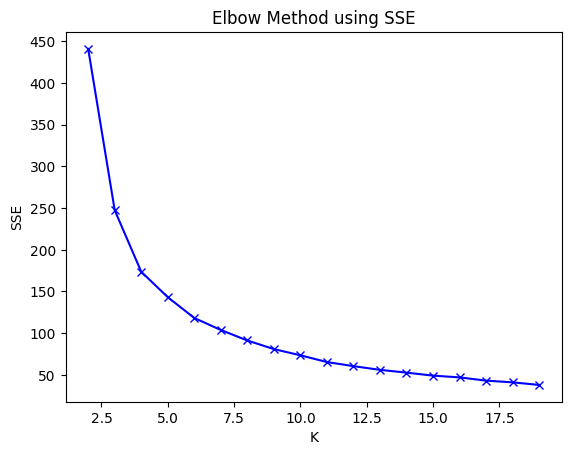

In [10]:
import matplotlib.pyplot as plt
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(2, 20), inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method using SSE')
plt.show()

In [11]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [12]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [13]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

def plot_gaussian_mixture(clf, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=3, colors='b')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    plt.tick_params(labelleft=False)

In [14]:
clf = KMeans(n_clusters=5, n_init='auto')

y_pred = clf.fit_predict(X)
y_pred

array([1, 1, 1, ..., 2, 2, 2])

In [15]:
clf_1 = KMeans(n_clusters=10, max_iter=1, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_5 = KMeans(n_clusters=10, max_iter=5, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_10 = KMeans(n_clusters=10, max_iter=10, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_300 = KMeans(n_clusters=10, max_iter=300, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_1.fit(X)
clf_5.fit(X)
clf_10.fit(X)
clf_300.fit(X)

KMeans(init='random', n_clusters=10, n_init=1, random_state=42)

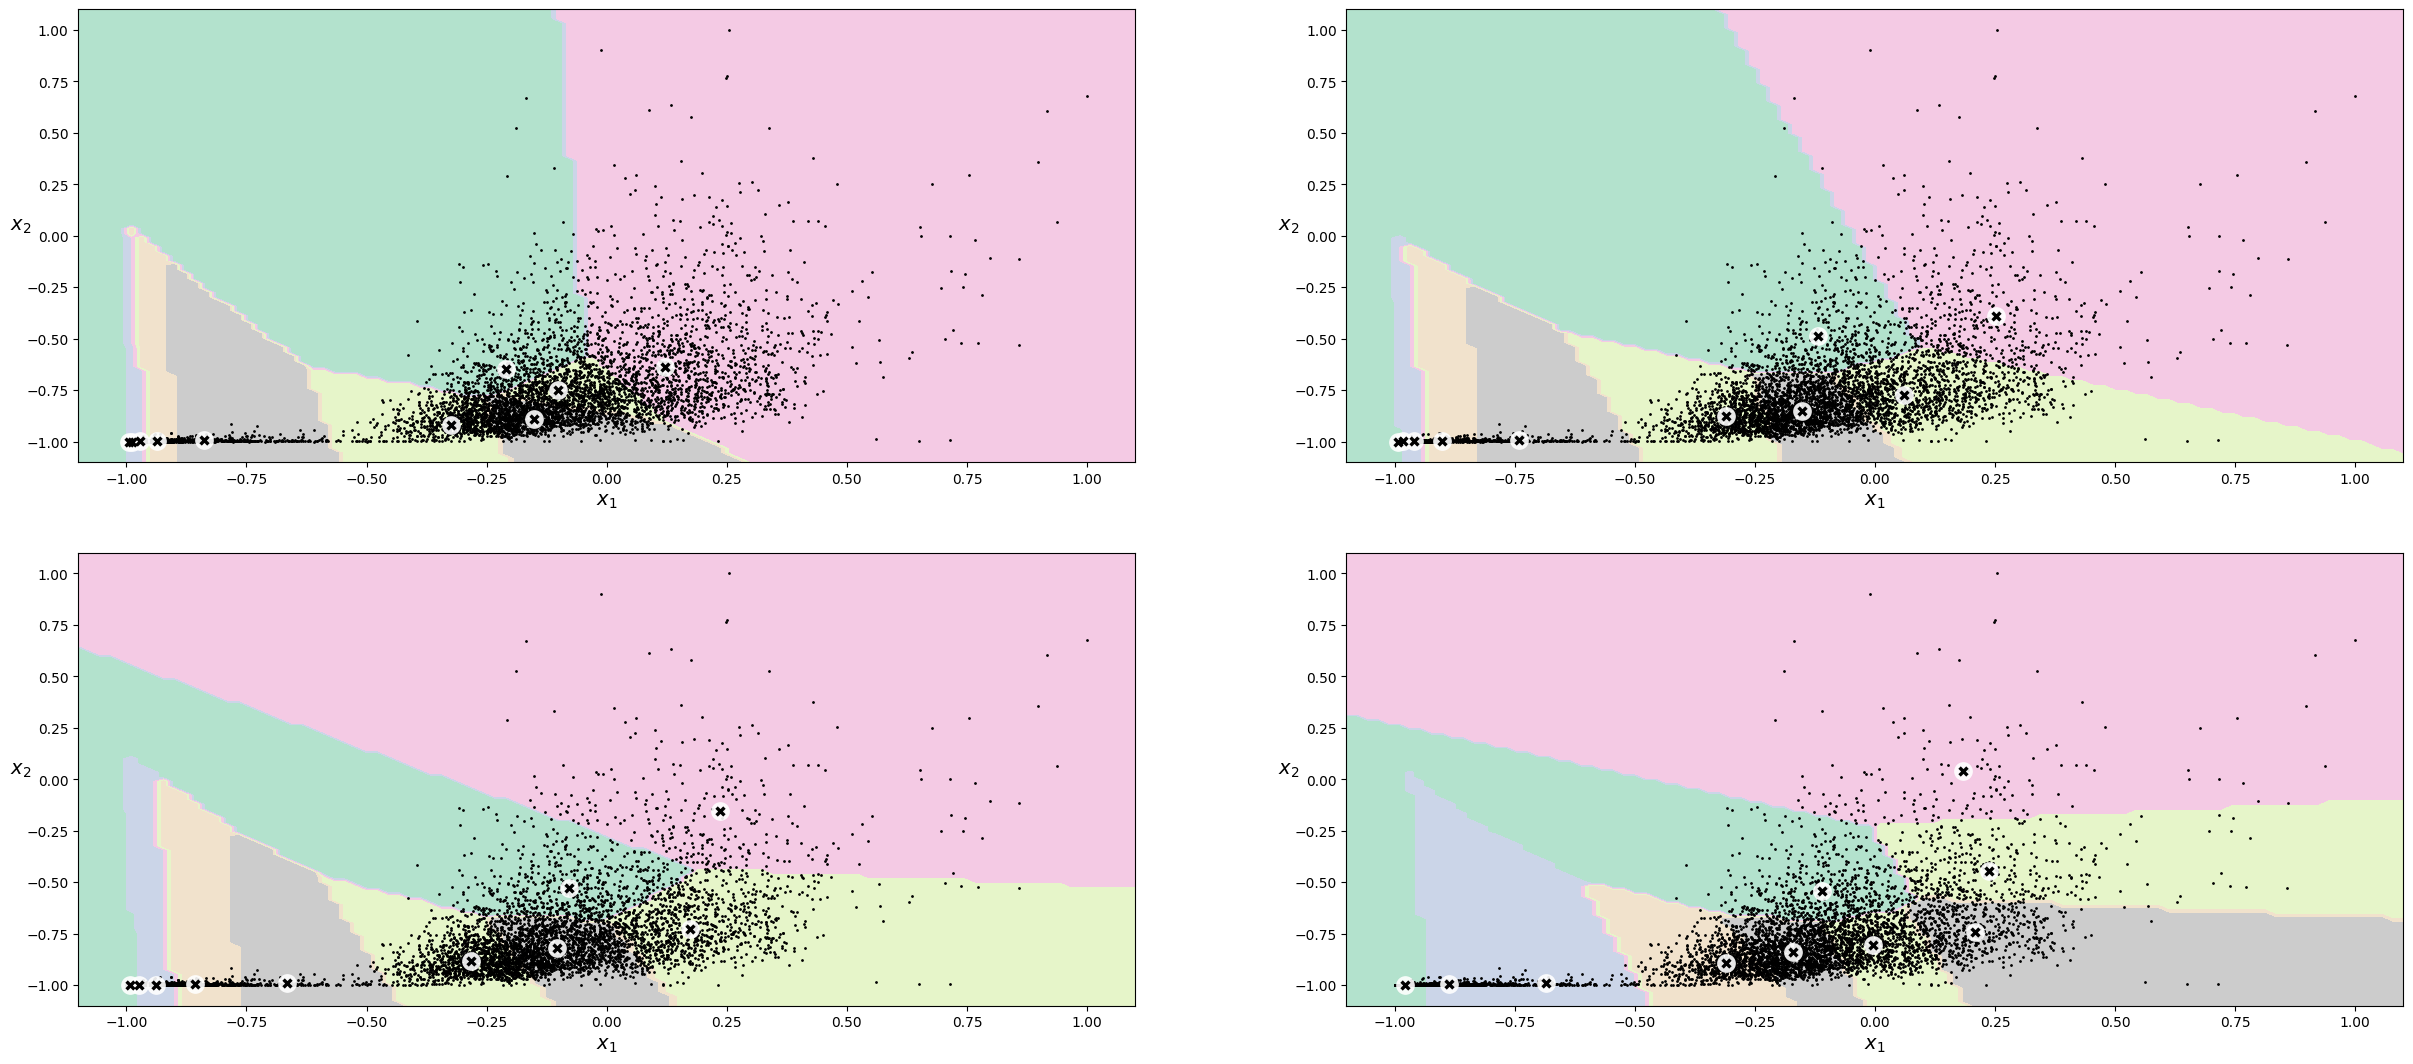

In [16]:
plt.figure(figsize=(30, 20))

plt.subplot(321)
plot_decision_boundaries(clf_1, X)

plt.subplot(322)
plot_decision_boundaries(clf_5, X)

plt.subplot(323)
plot_decision_boundaries(clf_10, X)

plt.subplot(324)
plot_decision_boundaries(clf_300, X)
plt.show()

In [17]:
y_flattened = np.ravel(y)  # spłaszczamy macież do 1D

silhouette_scores = [
    silhouette_score(X, y_flattened)
    for model in kmeans_per_k
]

# Używamy tzw silhouette_score

silhouette_scores = [
    silhouette_score(X, model.labels_)
    for model in kmeans_per_k[1:]
]

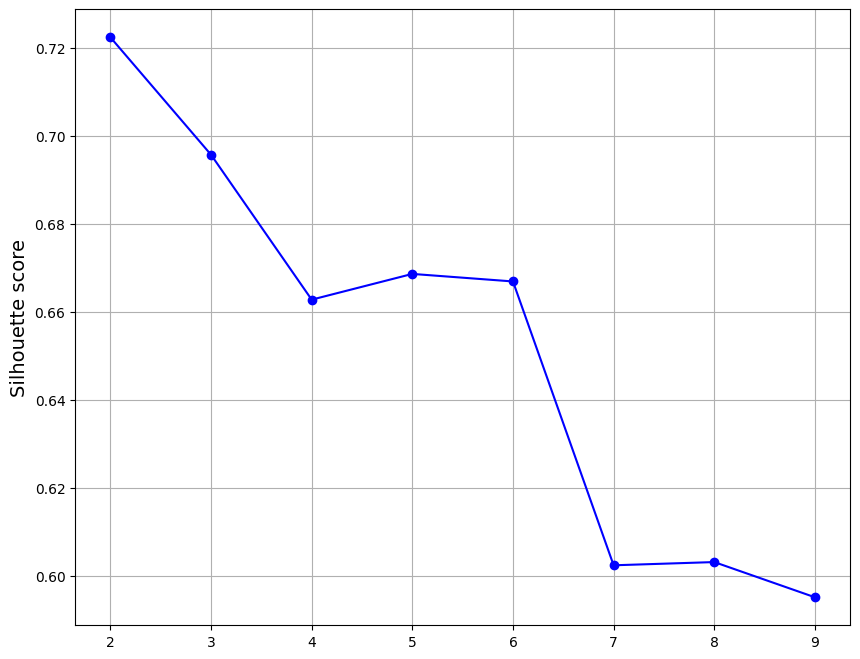

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(range(2, 10), silhouette_scores[:8], "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

##### Wybierzemy tutaj 5 klastrów

### KMeans

In [19]:
KMeans_clf = KMeans(n_clusters=5, max_iter=10, random_state=1, n_init='auto')
KMeans_clf.fit(X)

KMeans(max_iter=10, n_clusters=5, n_init='auto', random_state=1)

In [20]:
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=2, n_init='auto').fit(X)
    for k in range(2, 20)
]

In [21]:
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)
log_reg.fit(X_train, y_train)

print("Bez KMeans :", log_reg.score(X_test, y_test))

pipeline = Pipeline([
    ("kmeans", KMeans(
        n_clusters=5,
        random_state=2,
        n_init=5
    )),
    ("log_reg", LogisticRegression(
        multi_class="ovr",
        max_iter=5000,
        random_state=2
    )),
])
pipeline.fit(X_train, y_train)

print("Z KMeans :", pipeline.score(X_test, y_test))

Bez KMeans : 0.4497328800388538
Z KMeans : 0.4881010199125789


### DBSCAN

In [22]:
# tworzymy pierwszy klasyfikator DBSCAN z eps = 0.05
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

# drugi DBSCAN z eps = 0.2 (większy epsilon, większa przestrzeń wokół)
dbscan_2 = DBSCAN(eps=0.2, min_samples=5)
dbscan_2.fit(X)

DBSCAN(eps=0.2)

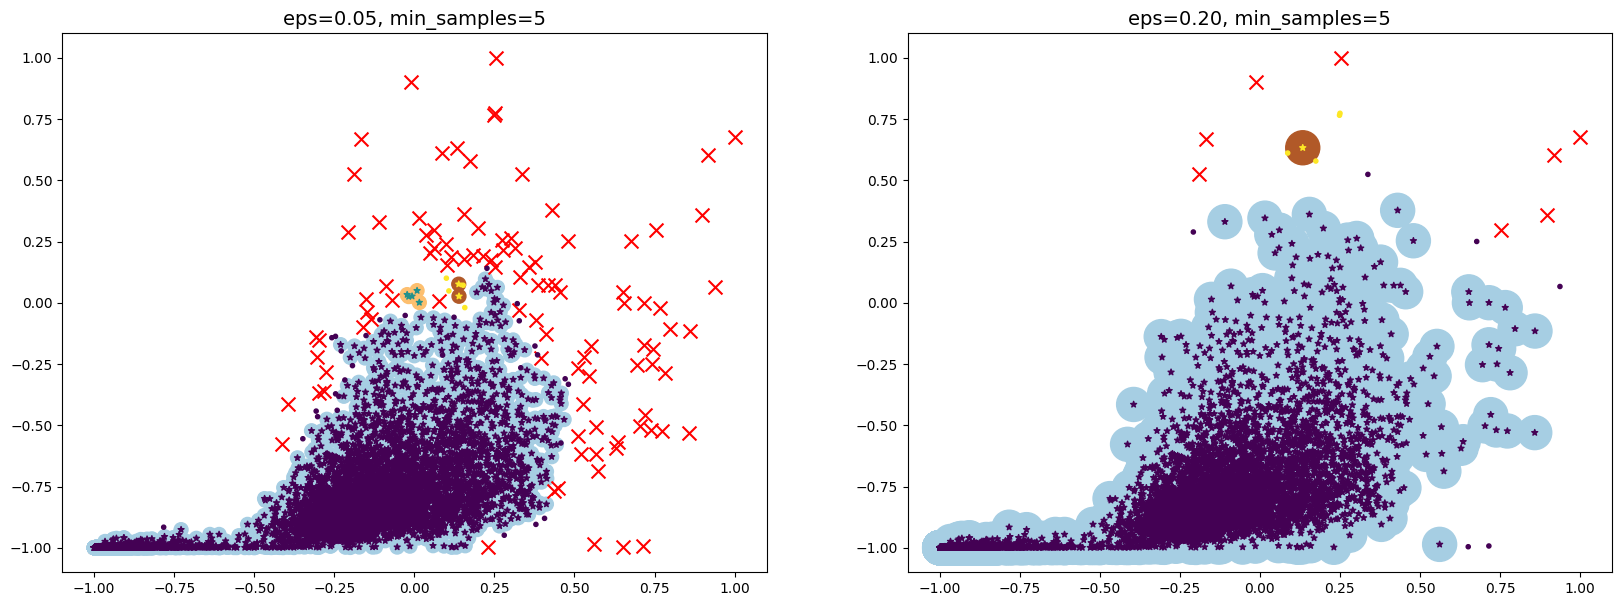

In [23]:
plt.figure(figsize=(20, 7))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan_2, X, size=600)

plt.show()

##### W przypadku eps=0.05 widać sporo anomalii. W przypadku eps=0.20 anomalii jest o wiele mniej

### Gaussian Mixture Models (GNN)

In [24]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type="tied")
gm.fit(X)

GaussianMixture(covariance_type='tied', n_components=3, n_init=10,
                random_state=42)

C:\Users\GTata\AppData\Local\Temp\ipykernel_32364\974971072.py:12: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\GTata\AppData\Local\Temp\ipykernel_32364\974971072.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


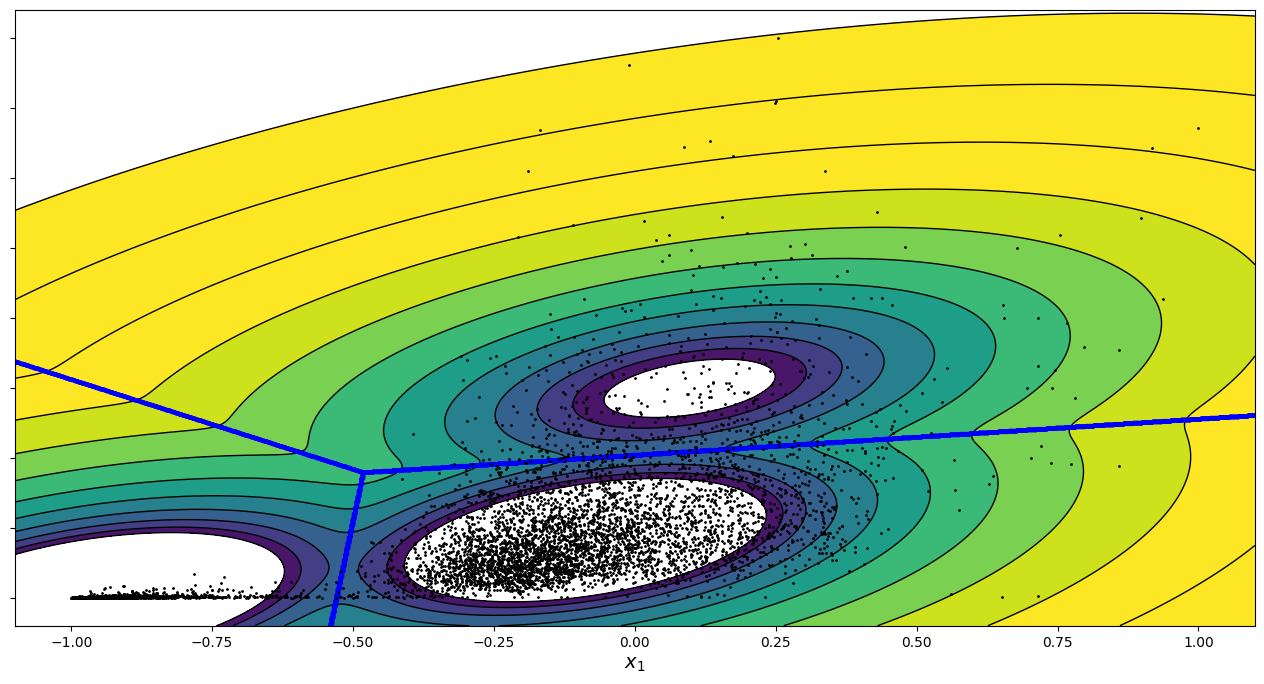

In [25]:
plt.figure(figsize=(16, 8))
plot_gaussian_mixture(gm, X)

### GMM - Odsiewanie anomalii

C:\Users\GTata\AppData\Local\Temp\ipykernel_32364\974971072.py:12: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\GTata\AppData\Local\Temp\ipykernel_32364\974971072.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


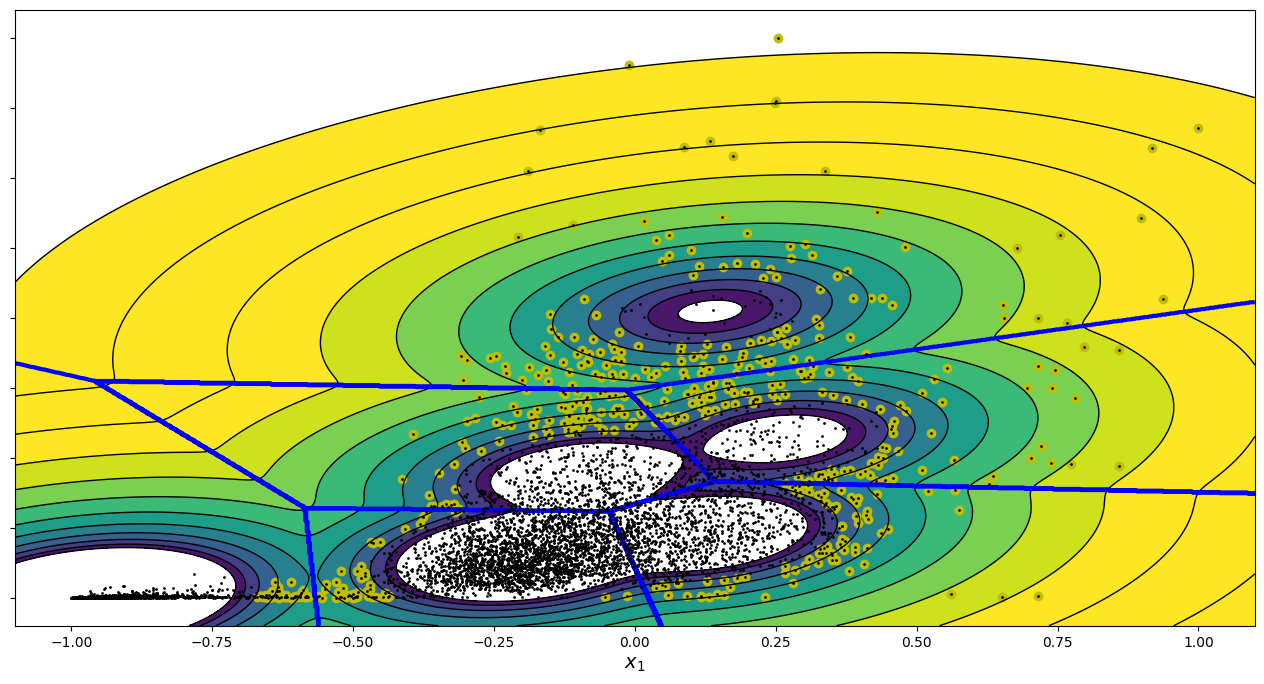

In [26]:
gm = GaussianMixture(n_components=6, n_init=10, random_state=42,covariance_type="tied")
gm.fit(X)

plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)

density = gm.score_samples(X)

threshold = np.percentile(density, 5)

anomalie = X[density < threshold]

plt.scatter(anomalie[:, 0], anomalie[:, 1], color='y', marker='o')
plt.show()